<a href="https://colab.research.google.com/github/marco-scatassi/TLDR_text_summarization/blob/main/featureMatrixAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root = '/content/drive/MyDrive/Unimib/Text_Mining/MARCO SCATASSI TEXT PROJECT/'
root2 = '/content/drive/MyDrive/Unimib/Text_Mining/Feature_matrices/'

In [5]:
import sys
sys.path.append('drive/MyDrive/Unimib/Text_Mining/MARCO SCATASSI TEXT PROJECT')

In [6]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 23.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


# Library Import - General


In [7]:
import pandas as pd
import numpy as np
import os

# Dataset loading 

In [ ]:
minorityClassPath = 'trainAndValMinorityClass.csv'
majorityClassPath = 'trainAndValMajorityClassUndersampled.csv'

In [ ]:
train = pd.concat(
    [pd.read_csv(minorityClassPath),
    pd.read_csv(majorityClassPath)]
)

# Exploration

## Library import

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from numpy.linalg import norm, pinv, matrix_rank
import random
from scipy.linalg import svd
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import matrix_rank

## Exploration

In [ ]:
train['ext_labels'] = train['ext_labels'].astype("category")

In [ ]:
features = train.columns.delete([0,-1])
features

Index(['sentence_relative_positions', 'word_in_sentence_relative',
       'POS_tag_ratio_NOUN', 'POS_tag_ratio_VERB', 'POS_tag_ratio_ADJ',
       'POS_tag_ratio_ADV', 'tf_isf_1_gram', 'sentence_similarity_1_gram'],
      dtype='object')

<AxesSubplot: >

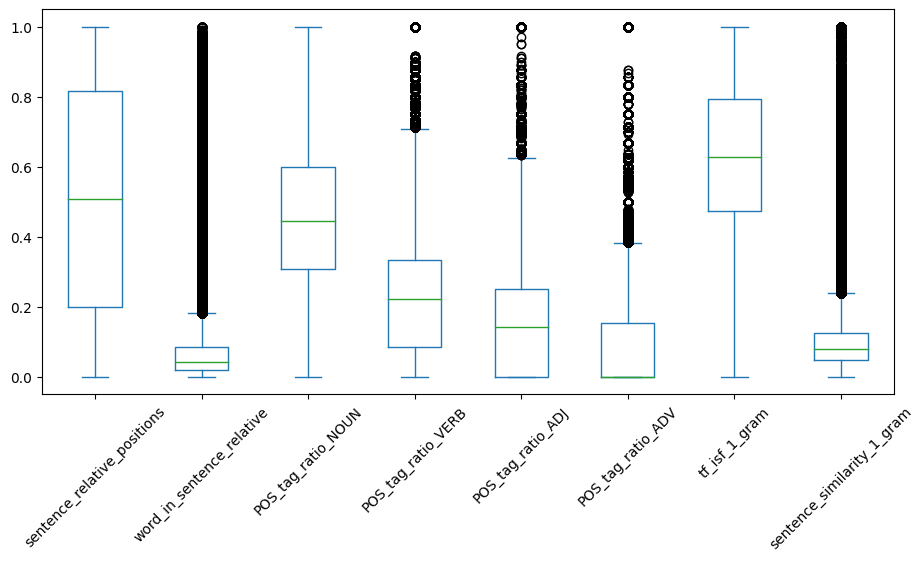

In [ ]:
train[features].plot.box(figsize=(11,5), rot=45)

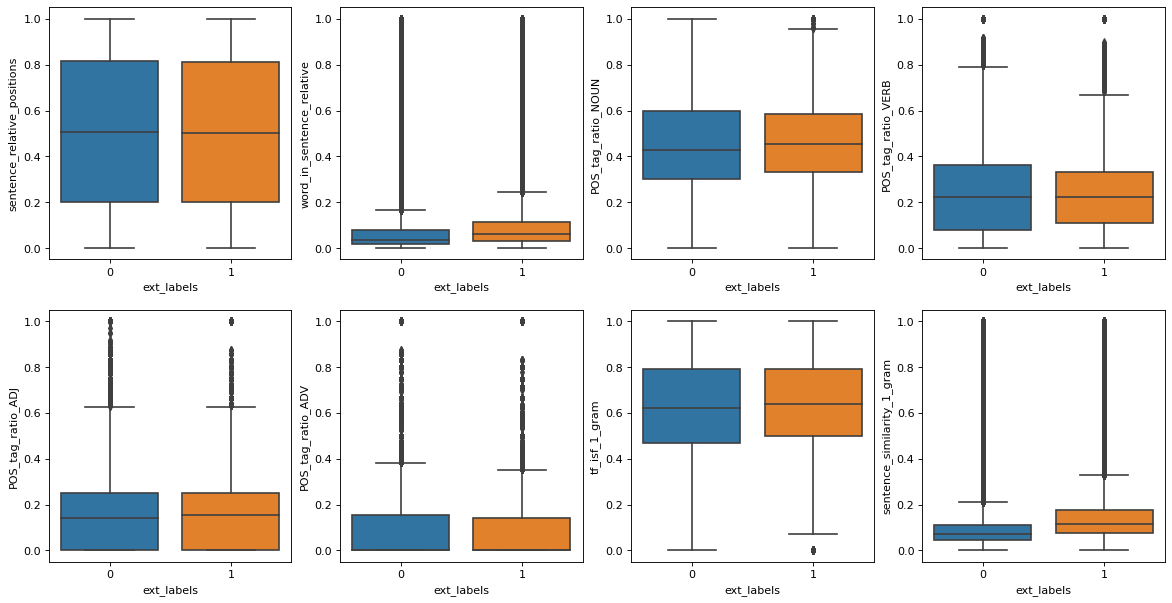

In [ ]:
plt.figure(figsize=(18, 9), dpi=80)

for i in range(len(features)):
  plt.subplot(2,4,i+1,)
  sns.boxplot(data=train, y=features[i], x='ext_labels')

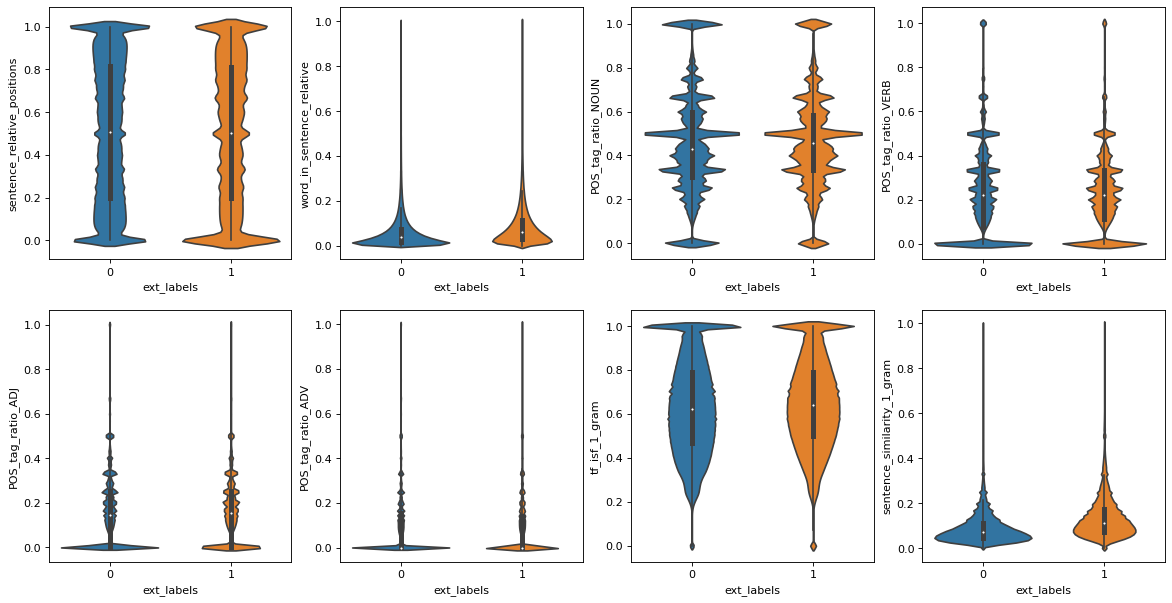

In [ ]:
plt.figure(figsize=(18, 9), dpi=80)

for i in range(len(features)):
  plt.subplot(2,4,i+1,)
  sns.violinplot(data=train, y=features[i], x='ext_labels')

<AxesSubplot: >

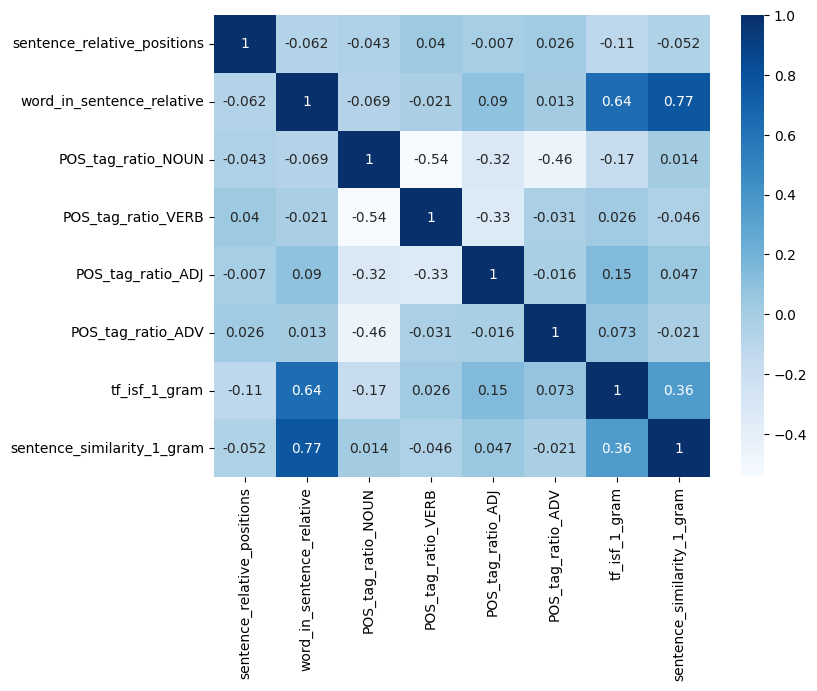

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
corr = train[features].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

# ML model


## Library import

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer, recall_score, precision_score, accuracy_score, f1_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC


## Preliminary

### ENN Undersampling

In [ ]:
X_train = train[features]
y_train = train.ext_labels

In [ ]:
# Initialize the undersampled method
enn = EditedNearestNeighbours(
    sampling_strategy = 'majority',
    n_neighbors=3,
    n_jobs = 6,
    kind_sel='all'
)

In [ ]:
enn.fit(X_train, y_train)

EditedNearestNeighbours(n_jobs=6, sampling_strategy='majority')

In [ ]:
X_res, y_res = enn.fit_resample(X_train, y_train)

In [ ]:
train_res = X_res
train_res['ext_labels'] = y_res

train_res.to_csv('trainAndValUndersampledENN3.csv', index=False)

In [ ]:
vc = train_res['ext_labels'].value_counts()
print(f'proportion of summary sentencies: {vc[1]/vc[0]}')

proportion of summary sentencies: 0.35392815663697574


Text(0.5, 1.0, 'Non summary vs Summary sentences')

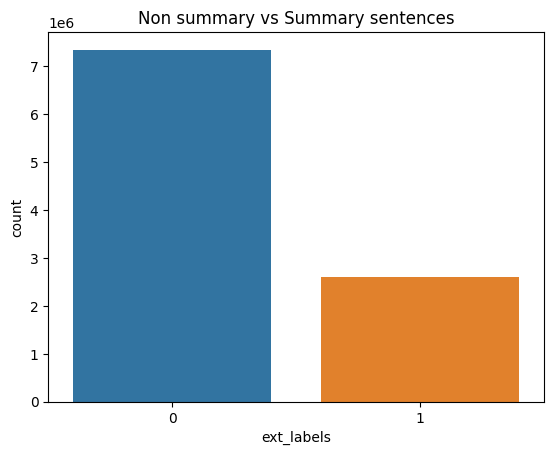

In [ ]:
fig, ax = plt.subplots()
sns.countplot(x=train_res['ext_labels'], ax=ax)
ax.set_title('Non summary vs Summary sentences')

### Test and train

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test

,document_index,sentence_relative_positions,word_in_sentence_relative,POS_tag_ratio_NOUN,POS_tag_ratio_VERB,POS_tag_ratio_ADJ,POS_tag_ratio_ADV,tf_isf_1_gram,sentence_similarity_1_gram,ext_labels
0,0,0.000000,0.057971,0.500000,0.250000,0.250000,0.000000,0.415837,0.246136,0
1,0,0.250000,0.188406,0.846154,0.076923,0.000000,0.076923,0.723293,0.210210,0
2,0,0.500000,0.159420,0.636364,0.090909,0.181818,0.090909,0.661245,0.200000,0
3,0,0.750000,0.376812,0.769231,0.000000,0.153846,0.000000,1.000000,0.233513,0
4,0,1.000000,0.217391,0.533333,0.133333,0.266667,0.000000,0.807252,0.235947,1
...,...,...,...,...,...,...,...,...,...,...
646737,13370,0.973510,0.009270,0.375000,0.375000,0.000000,0.125000,0.777718,0.023198,0
646738,13370,0.980132,0.008111,0.285714,0.428571,0.142857,0.000000,0.723137,0.023694,0
646739,13370,0.986755,0.009270,0.375000,0.375000,0.125000,0.125000,0.781199,0.023275,0
646740,13370,0.993377,0.004635,0.750000,0.250000,0.000000,0.000000,0.553723,0.043080,0


In [ ]:
train = pd.read_csv(root+'trainAndValUndersampledENN3.csv')
train

,sentence_relative_positions,word_in_sentence_relative,POS_tag_ratio_NOUN,POS_tag_ratio_VERB,POS_tag_ratio_ADJ,POS_tag_ratio_ADV,tf_isf_1_gram,sentence_similarity_1_gram,ext_labels
0,0.111111,0.016878,0.000000,0.000000,0.500000,0.5,0.424720,0.044131,0
1,0.148148,0.016878,0.750000,0.000000,0.250000,0.0,0.415305,0.062331,0
2,0.259259,0.008439,1.000000,0.000000,0.000000,0.0,0.300834,0.035714,0
3,0.296296,0.008439,0.000000,0.500000,0.000000,0.5,0.300322,0.043229,0
4,0.370370,0.012658,0.666667,0.333333,0.000000,0.0,0.364011,0.053351,0
...,...,...,...,...,...,...,...,...,...
9945059,0.416667,0.046296,0.000000,0.600000,0.000000,0.4,0.530141,0.102545,1
9945060,0.583333,0.138889,0.266667,0.400000,0.133333,0.2,0.880657,0.141249,1
9945061,0.500000,0.044118,0.666667,0.000000,0.333333,0.0,0.446388,0.162459,1
9945062,0.833333,0.058824,0.500000,0.250000,0.250000,0.0,0.434094,0.166664,1


In [ ]:
features = train.columns.drop(['ext_labels'])

In [ ]:
features

Index(['sentence_relative_positions', 'word_in_sentence_relative',
       'POS_tag_ratio_NOUN', 'POS_tag_ratio_VERB', 'POS_tag_ratio_ADJ',
       'POS_tag_ratio_ADV', 'tf_isf_1_gram', 'sentence_similarity_1_gram'],
      dtype='object')

## Models definition

In [ ]:
X_train = train[features]
y_train = train.ext_labels

In [ ]:
def naiveScoreFunction(estimator, X, y):
    y_true = pd.Series(y)
    y_pred_proba = pd.Series(estimator.predict_proba(X)[:,1])
    y_pred = y_pred_proba.sort_values(ascending=False)
    #print(y_pred)

    # minority class
    y_true1_index = set(y_true.where(y_true==1).dropna().index)
    minority_y_true = len(y_true1_index)

    y_pred_within_minority_y_true = y_pred.iloc[:minority_y_true]
    y_pred_within_minority_y_true_index = set(y_pred_within_minority_y_true.index)

    num_matching_minority_index = len(y_true1_index & y_pred_within_minority_y_true_index)

    minority_score = num_matching_minority_index/abs(len(y_true[y_true==1])+0.0001)

    
    return minority_score

In [ ]:
naiveScorer = make_scorer(
    naiveScoreFunction,
    greater_is_better=True,
    needs_threshold=True
)

In [ ]:
# Initialze the estimators
clf1 = RandomForestClassifier(
    n_jobs=5,
    oob_score=False,
    verbose=1,
    random_state=100
)

In [ ]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier__max_depth'] = [16, 25]
param1['classifier__n_estimators'] = [50, 80]
param1['classifier__min_samples_split'] = [2, 20]
param1['classifier__class_weight'] = [{0: 1, 1: 3}, {0: 1, 1: 5}]
param1['classifier'] = [clf1]

In [ ]:
clf2 = LogisticRegression(
    verbose=2,
    random_state=100,
    n_jobs=5
)

In [ ]:
param2 = {}
param2['classifier__penalty'] = [None]
param2['classifier__class_weight'] = [{0: 1, 1: 3}, {0: 1, 1: 5}]
param2['classifier__max_iter'] = [500]
param2['classifier'] = [clf2]

In [ ]:
clf3 = HistGradientBoostingClassifier(
    verbose=2,
    random_state=100
)

In [ ]:
param3 = {}
param3['classifier__learning_rate'] = [0.05]
param3['classifier__max_iter'] = [500]
param3['classifier__max_bins'] = [127, 255]
param3['classifier__class_weight'] = [{0: 1, 1: 3}, {0: 1, 1: 5}]
param3['classifier'] = [clf3]

In [ ]:
pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3]

## RandomizedSearchCV

In [ ]:
def refit_strategy(cv_result):

    def print_dataframe(filtered_cv_results):
        """Pretty print for filtered dataframe"""
        for mean_precision, std_precision, mean_recall, std_recall, mean_f1, std_f1, mean_roc_auc, std_roc_auc, params in zip(
            filtered_cv_results["mean_test_precision"],
            filtered_cv_results["std_test_precision"],
            filtered_cv_results["mean_test_recall"],
            filtered_cv_results["std_test_recall"],
            filtered_cv_results["mean_test_f1"],
            filtered_cv_results["std_test_f1"],
            filtered_cv_results["mean_test_roc_auc"],
            filtered_cv_results["std_test_roc_auc"],
            filtered_cv_results["params"],
        ):
            print(
                f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
                f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
                f"precision: {mean_f1:0.3f} (±{std_f1:0.03f}),"
                f" recall: {mean_roc_auc:0.3f} (±{std_roc_auc:0.03f}),"
                f" for {params}"
            )

        print()

    cv_results_ = pd.DataFrame(cv_result)

    print("All grid-search results:")
    print_dataframe(cv_results_)

    cv_results_ = cv_results_[['mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']]

    count = cv_results_.apply(lambda x: (cv_results_ <= x).sum(axis=0)-1, axis=1)
    count = count.sum(axis=1)

    best_model_index = count.idxmax()

    return best_model_index


In [ ]:
gs = RandomizedSearchCV(pipeline, 
                        params, 
                        cv=3, 
                        n_jobs=1, 
                        verbose=3,
                        random_state=10,
                        refit=refit_strategy,
                        return_train_score=True,
                        n_iter=10,
                        scoring={
                            'f1': make_scorer(f1_score), 
                            'roc_auc': make_scorer(roc_auc_score), 
                            'recall': make_scorer(recall_score), 
                            'precision': make_scorer(precision_score)
                            })

gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.7s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   19.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   31.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   39.3s finished


[CV 1/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.701, test=0.592) precision: (train=0.572, test=0.494) recall: (train=0.905, test=0.739) roc_auc: (train=0.832, test=0.735) total time= 3.6min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.8min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.8s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   23.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   35.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   44.5s finished


[CV 2/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.698, test=0.589) precision: (train=0.568, test=0.474) recall: (train=0.906, test=0.776) roc_auc: (train=0.831, test=0.736) total time= 4.3min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  4.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   20.3s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   25.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   39.2s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   49.0s finished


[CV 3/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.699, test=0.590) precision: (train=0.570, test=0.485) recall: (train=0.905, test=0.754) roc_auc: (train=0.832, test=0.735) total time= 5.0min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.7min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  7.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.9s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   50.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   47.7s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  1.6min finished


[CV 1/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=2, classifier__n_estimators=80; f1: (train=0.829, test=0.597) precision: (train=0.784, test=0.606) recall: (train=0.881, test=0.587) roc_auc: (train=0.897, test=0.726) total time= 8.4min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  6.0min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   20.1s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   39.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   36.3s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  1.2min finished


[CV 2/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=2, classifier__n_estimators=80; f1: (train=0.829, test=0.605) precision: (train=0.782, test=0.585) recall: (train=0.882, test=0.627) roc_auc: (train=0.897, test=0.735) total time= 6.7min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.0min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  6.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   20.4s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   42.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   38.9s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  1.3min finished


[CV 3/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=2, classifier__n_estimators=80; f1: (train=0.828, test=0.601) precision: (train=0.781, test=0.597) recall: (train=0.881, test=0.605) roc_auc: (train=0.897, test=0.730) total time= 7.0min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    9.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.8s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   17.5s finished


[CV 1/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.606, test=0.591) precision: (train=0.513, test=0.509) recall: (train=0.742, test=0.705) roc_auc: (train=0.746, test=0.732) total time= 3.4min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    8.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   17.0s finished


[CV 2/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.605, test=0.590) precision: (train=0.511, test=0.489) recall: (train=0.741, test=0.745) roc_auc: (train=0.745, test=0.735) total time= 3.6min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.2min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.3s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   13.4s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   16.8s finished


[CV 3/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.606, test=0.590) precision: (train=0.512, test=0.501) recall: (train=0.742, test=0.718) roc_auc: (train=0.746, test=0.732) total time= 3.4min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.5min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  5.0min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   12.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.3s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   24.2s finished


[CV 1/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.571, test=0.562) precision: (train=0.427, test=0.425) recall: (train=0.862, test=0.831) roc_auc: (train=0.726, test=0.716) total time= 5.3min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  4.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    6.4s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   12.5s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.7s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   23.8s finished


[CV 2/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.569, test=0.554) precision: (train=0.424, test=0.408) recall: (train=0.863, test=0.860) roc_auc: (train=0.724, test=0.709) total time= 4.8min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  4.7min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.0s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   14.2s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   14.0s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   27.4s finished


[CV 3/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.571, test=0.558) precision: (train=0.426, test=0.418) recall: (train=0.863, test=0.841) roc_auc: (train=0.726, test=0.713) total time= 5.0min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  6.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   17.3s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   34.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   35.1s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  1.2min finished


[CV 1/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.728, test=0.601) precision: (train=0.663, test=0.566) recall: (train=0.808, test=0.641) roc_auc: (train=0.831, test=0.734) total time= 7.1min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  6.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   20.5s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   40.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   33.3s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  1.1min finished


[CV 2/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.728, test=0.606) precision: (train=0.662, test=0.545) recall: (train=0.809, test=0.682) roc_auc: (train=0.831, test=0.740) total time= 7.1min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  5.8min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.0s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   30.9s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   31.9s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  1.1min finished


[CV 3/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.727, test=0.603) precision: (train=0.661, test=0.557) recall: (train=0.808, test=0.658) roc_auc: (train=0.831, test=0.736) total time= 6.4min
Binning 0.382 GB of training data: 0.539 s
Binning 0.042 GB of validation data: 0.044 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 31 leaves, max depth = 7, train loss: 0.68120, val loss: 0.68117, in 0.250s
[2/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.67075, val loss: 0.67070, in 0.248s
[3/500] 1 tree, 31 leaves, max depth = 7, train loss: 0.66125, val loss: 0.66120, in 0.237s
[4/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.65264, val loss: 0.65257, in 0.250s
[5/500] 1 tree, 31 leaves, max depth = 9, train loss: 0.64473, val loss: 0.64465, in 0.254s
[6/500] 1 tree, 31 leaves, max depth = 8, train l

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  4.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.6s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   11.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   11.1s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   23.0s finished


[CV 1/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.607, test=0.591) precision: (train=0.513, test=0.509) recall: (train=0.742, test=0.705) roc_auc: (train=0.746, test=0.732) total time= 4.5min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  4.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   11.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   12.7s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   25.0s finished


[CV 2/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.605, test=0.590) precision: (train=0.511, test=0.489) recall: (train=0.741, test=0.746) roc_auc: (train=0.745, test=0.735) total time= 4.5min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  4.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   11.0s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   10.7s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:   22.7s finished


[CV 3/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=16, classifier__min_samples_split=20, classifier__n_estimators=80; f1: (train=0.606, test=0.590) precision: (train=0.512, test=0.501) recall: (train=0.742, test=0.718) roc_auc: (train=0.746, test=0.733) total time= 4.5min
Binning 0.382 GB of training data: 0.474 s
Binning 0.042 GB of validation data: 0.037 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 31 leaves, max depth = 7, train loss: 0.64322, val loss: 0.64319, in 0.241s
[2/500] 1 tree, 31 leaves, max depth = 7, train loss: 0.63343, val loss: 0.63338, in 0.244s
[3/500] 1 tree, 31 leaves, max depth = 7, train loss: 0.62460, val loss: 0.62455, in 0.236s
[4/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.61656, val loss: 0.61649, in 0.212s
[5/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.60923, val loss: 0.60915, in 0.224s
[6/500] 1 tree, 31 leaves, max depth = 7, train l

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   19.1s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   30.3s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   38.1s finished


[CV 1/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.727, test=0.600) precision: (train=0.662, test=0.565) recall: (train=0.807, test=0.641) roc_auc: (train=0.831, test=0.733) total time= 3.7min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.0s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   18.8s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   30.0s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   38.0s finished


[CV 2/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.727, test=0.605) precision: (train=0.661, test=0.544) recall: (train=0.808, test=0.681) roc_auc: (train=0.830, test=0.740) total time= 3.7min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.3min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   15.4s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   19.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   29.2s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   36.7s finished


[CV 3/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 3}, classifier__max_depth=25, classifier__min_samples_split=20, classifier__n_estimators=50; f1: (train=0.725, test=0.602) precision: (train=0.659, test=0.555) recall: (train=0.807, test=0.658) roc_auc: (train=0.830, test=0.736) total time= 3.7min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   17.9s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   22.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   34.9s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   43.9s finished


[CV 1/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=25, classifier__min_samples_split=2, classifier__n_estimators=50; f1: (train=0.786, test=0.596) precision: (train=0.675, test=0.533) recall: (train=0.942, test=0.675) roc_auc: (train=0.890, test=0.733) total time= 3.9min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.5min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.1s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   22.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   35.1s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   44.3s finished


[CV 2/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=25, classifier__min_samples_split=2, classifier__n_estimators=50; f1: (train=0.784, test=0.597) precision: (train=0.671, test=0.514) recall: (train=0.942, test=0.712) roc_auc: (train=0.889, test=0.737) total time= 3.9min


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  3.4min finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   17.9s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   22.6s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   38.5s
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:   48.4s finished


[CV 3/3] END classifier=RandomForestClassifier(n_jobs=5, random_state=100, verbose=1), classifier__class_weight={0: 1, 1: 5}, classifier__max_depth=25, classifier__min_samples_split=2, classifier__n_estimators=50; f1: (train=0.783, test=0.596) precision: (train=0.670, test=0.523) recall: (train=0.942, test=0.692) roc_auc: (train=0.889, test=0.734) total time= 3.9min
All grid-search results:
precision: 0.484 (±0.008), recall: 0.756 (±0.015),precision: 0.590 (±0.001), recall: 0.735 (±0.000), for {'classifier__n_estimators': 50, 'classifier__min_samples_split': 20, 'classifier__max_depth': 25, 'classifier__class_weight': {0: 1, 1: 5}, 'classifier': RandomForestClassifier(n_jobs=5, random_state=100, verbose=1)}
precision: 0.596 (±0.009), recall: 0.606 (±0.016),precision: 0.601 (±0.004), recall: 0.730 (±0.004), for {'classifier__n_estimators': 80, 'classifier__min_samples_split': 2, 'classifier__max_depth': 25, 'classifier__class_weight': {0: 1, 1: 3}, 'classifier': RandomForestClassifier(n

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  8.5min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('classifier',
                                              RandomForestClassifier(class_weight={0: 1,
                                                                                   1: 3},
                                                                     max_depth=25,
                                                                     min_samples_split=20,
                                                                     n_estimators=80,
                                                                     n_jobs=5,
                                                                     random_state=100,
                                                                     verbose=1))]),
                   n_jobs=1,
                   param_distributions=[{'classifier': [RandomForestClassifier(class_weight={0: 1,
                                                                                             1: 3},
                                                                               max_depth=25,
                                                                               min_samples_split=20,
                                                                               n_estimators=80,
                                                                               n_jobs=5,...
                                                                      {0: 1,
                                                                       1: 5}],
                                         'classifier__learning_rate': [0.05],
                                         'classifier__max_bins': [127, 255],
                                         'classifier__max_iter': [500]}],
                   random_state=10,
                   refit=<function refit_strategy at 0x17708b9c0>,
                   return_train_score=True,
                   scoring={'f1': make_scorer(f1_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score),
                            'roc_auc': make_scorer(roc_auc_score)},
                   verbose=3)

In [ ]:
cv_ =pd.DataFrame(gs.cv_results_).to_csv('cv_results.csv', index=False)

In [ ]:
cv_ = pd.read_csv('cv_results.csv')
cv_

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_estimators,param_classifier__min_samples_split,param_classifier__max_depth,param_classifier__class_weight,param_classifier,param_classifier__max_iter,...,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_train_precision,split1_train_precision,split2_train_precision,mean_train_precision,std_train_precision
0,231.503436,31.389511,25.686387,2.434259,50.0,20.0,25.0,"{0: 1, 1: 5}","RandomForestClassifier(class_weight={0: 1, 1: ...",NaN,...,0.474146,0.484752,0.484143,0.007925,8,0.571770,0.567842,0.569576,0.569730,0.001607
1,395.372851,40.702478,47.001445,4.787248,80.0,2.0,25.0,"{0: 1, 1: 3}","RandomForestClassifier(class_weight={0: 1, 1: ...",NaN,...,0.585401,0.597146,0.596290,0.008563,1,0.783525,0.781604,0.780892,0.782007,0.001112
2,196.621535,4.089125,11.910893,0.379833,50.0,20.0,16.0,"{0: 1, 1: 3}","RandomForestClassifier(class_weight={0: 1, 1: ...",NaN,...,0.488673,0.500678,0.499294,0.008166,6,0.512534,0.511099,0.512273,0.511969,0.000624
3,284.390992,12.279752,15.743733,0.757853,80.0,20.0,16.0,"{0: 1, 1: 5}","RandomForestClassifier(class_weight={0: 1, 1: ...",NaN,...,0.408117,0.417947,0.416905,0.006790,9,0.427072,0.424485,0.426425,0.425994,0.001099
4,373.084541,16.570884,38.004822,3.695186,80.0,20.0,25.0,"{0: 1, 1: 3}","RandomForestClassifier(class_weight={0: 1, 1: ...",NaN,...,0.545087,0.556918,0.556008,0.008569,2,0.663290,0.661622,0.660973,0.661962,0.000976
5,110.893929,3.404598,19.392759,0.051465,NaN,NaN,NaN,"{0: 1, 1: 3}",HistGradientBoostingClassifier(random_state=10...,500.0,...,0.483963,0.495636,0.494604,0.008300,7,0.496570,0.493466,0.495005,0.495014,0.001267
6,258.721291,0.398161,13.906456,0.233650,80.0,20.0,16.0,"{0: 1, 1: 3}","RandomForestClassifier(class_weight={0: 1, 1: ...",NaN,...,0.488576,0.500893,0.499442,0.008343,5,0.512978,0.511108,0.512478,0.512188,0.000791
7,109.106045,2.482296,19.586093,0.629675,NaN,NaN,NaN,"{0: 1, 1: 5}",HistGradientBoostingClassifier(random_state=10...,500.0,...,0.404489,0.413796,0.412732,0.006340,10,0.413883,0.411861,0.413221,0.412988,0.000842
8,200.573108,0.436631,21.877857,0.161110,50.0,20.0,25.0,"{0: 1, 1: 3}","RandomForestClassifier(class_weight={0: 1, 1: ...",NaN,...,0.543931,0.555205,0.554632,0.008514,3,0.662198,0.660527,0.658624,0.660450,0.001460
9,207.972523,1.700008,25.464804,0.020379,50.0,2.0,25.0,"{0: 1, 1: 5}","RandomForestClassifier(class_weight={0: 1, 1: ...",NaN,...,0.513831,0.522889,0.523381,0.008006,4,0.674547,0.671143,0.670140,0.671943,0.001886


In [ ]:
for i in range(10):
    print('\nmodello: ', str(i), '\n')
    df = pd.DataFrame()
    df['train']=list(pd.DataFrame(gs.cv_results_)[['mean_train_precision', 'mean_train_recall', 'mean_train_f1', 'mean_train_roc_auc']].iloc[i])
    df['test']=list(pd.DataFrame(gs.cv_results_)[['mean_test_precision', 'mean_test_recall', 'mean_test_f1', 'mean_test_roc_auc']].iloc[i])
    df['generalizzazione']=abs(df['train']-df['test'])
    df.index=[['precision', 'recall', 'f1', 'roc_auc']]
    print(df)


modello:  0 

              train      test  generalizzazione
precision  0.569730  0.484143          0.085587
recall     0.905234  0.756304          0.148930
f1         0.699322  0.590184          0.109138
roc_auc    0.831633  0.735383          0.096251

modello:  1 

              train      test  generalizzazione
precision  0.782007  0.596290          0.185717
recall     0.881170  0.606482          0.274688
f1         0.828632  0.601091          0.227541
roc_auc    0.897116  0.730471          0.166644

modello:  2 

              train      test  generalizzazione
precision  0.511969  0.499294          0.012675
recall     0.741632  0.722842          0.018790
f1         0.605763  0.590400          0.015363
roc_auc    0.745710  0.732976          0.012735

modello:  3 

              train      test  generalizzazione
precision  0.425994  0.416905          0.009089
recall     0.862884  0.843916          0.018968
f1         0.570392  0.557984          0.012407
roc_auc    0.725684  0.71290

### Selected model

In [ ]:
final_model_param = {'classifier__max_iter': 500, 'classifier__max_bins': 255, 'classifier__learning_rate': 0.05, 'classifier__class_weight': {0: 1, 1: 3}, 'classifier': HistGradientBoostingClassifier(random_state=100, verbose=2)}

In [ ]:
final_model = HistGradientBoostingClassifier(
    random_state=100, verbose=2,
    max_iter=final_model_param['classifier__max_iter'],
    max_bins=final_model_param['classifier__max_bins'],
    learning_rate=final_model_param['classifier__learning_rate'],
    class_weight=final_model_param['classifier__class_weight']
)

TypeError: ignored

In [ ]:
final_model.fit(X_train, y_train)

Binning 0.573 GB of training data: 0.710 s
Binning 0.064 GB of validation data: 0.061 s
Fitting gradient boosted rounds:
[1/500] 1 tree, 31 leaves, max depth = 7, train loss: 0.68126, val loss: 0.68124, in 0.346s
[2/500] 1 tree, 31 leaves, max depth = 7, train loss: 0.67094, val loss: 0.67090, in 0.352s
[3/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.66150, val loss: 0.66144, in 0.379s
[4/500] 1 tree, 31 leaves, max depth = 9, train loss: 0.65287, val loss: 0.65280, in 0.424s
[5/500] 1 tree, 31 leaves, max depth = 9, train loss: 0.64502, val loss: 0.64494, in 0.349s
[6/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.63782, val loss: 0.63774, in 0.381s
[7/500] 1 tree, 31 leaves, max depth = 9, train loss: 0.63122, val loss: 0.63114, in 0.396s
[8/500] 1 tree, 31 leaves, max depth = 8, train loss: 0.62522, val loss: 0.62512, in 0.423s
[9/500] 1 tree, 31 leaves, max depth = 7, train loss: 0.61968, val loss: 0.61958, in 0.343s
[10/500] 1 tree, 31 leaves, max depth = 8, train lo

HistGradientBoostingClassifier(class_weight={0: 1, 1: 3}, learning_rate=0.05,
                               max_iter=500, random_state=100, verbose=2)

### Model Saving

In [ ]:
import pickle
pickle.dump(final_model, open('final_model.pickle','wb'))

## Evaluation

In [ ]:
test = pd.read_csv(root2+'test.csv')

In [ ]:
features = test.columns.delete([0,-1])
features

Index(['sentence_relative_positions', 'word_in_sentence_relative',
       'POS_tag_ratio_NOUN', 'POS_tag_ratio_VERB', 'POS_tag_ratio_ADJ',
       'POS_tag_ratio_ADV', 'tf_isf_1_gram', 'sentence_similarity_1_gram'],
      dtype='object')

In [ ]:
def plot_ROC(model, X_train, y_train, X_test=[], y_test=[], test=True, svc=False):
    if svc:
        y_train_proba = y_train_proba = model.decision_function(X_train)
    else:
        y_train_proba = model.predict_proba(X_train)[:,1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    fpr, tpr, _ = roc_curve(y_train, y_train_proba)
    roc_auc = auc(fpr, tpr)
    print(f'Train AUC {roc_auc:.3f}')

    ax1.plot(fpr, tpr, label="ROC curve")
    ax1.plot([0, 1], [0, 1])
    ax1.set_xlabel("False Positive Rate")
    ax1.set_ylabel("True Positive Rate")
    ax1.set_title("Train-Receiver operating characteristic")
    ax1.legend(loc="lower right")
    
    if test:
        if svc:
            y_test_proba = model.decision_function( X_test)
        else:
            y_test_proba = model.predict_proba( X_test)[:,1]
        
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = auc(fpr, tpr)
        print(f'Test AUC {roc_auc:.3f}')

        ax2.plot(fpr, tpr, label="ROC curve")
        ax2.plot([0, 1], [0, 1])
        ax2.set_xlabel("False Positive Rate")
        ax2.set_ylabel("True Positive Rate")
        ax2.set_title("Test-Receiver operating characteristic")
        ax2.legend(loc="lower right")

    plt.show()

In [ ]:
n_doc = 5
X_test = test[test.document_index==n_doc][features]
y_test = test[test.document_index==n_doc].ext_labels

In [ ]:
X_test

,sentence_relative_positions,word_in_sentence_relative,POS_tag_ratio_NOUN,POS_tag_ratio_VERB,POS_tag_ratio_ADJ,POS_tag_ratio_ADV,tf_isf_1_gram,sentence_similarity_1_gram
140,0.000000,0.022624,0.600000,0.000000,0.200000,0.200000,0.440487,0.062119
141,0.052632,0.095023,0.333333,0.190476,0.142857,0.285714,0.863832,0.084476
142,0.105263,0.063348,0.428571,0.000000,0.214286,0.285714,0.710390,0.104715
143,0.157895,0.054299,0.416667,0.416667,0.166667,0.000000,0.620879,0.076203
144,0.210526,0.013575,0.333333,0.000000,0.333333,0.333333,0.341811,0.067052
145,0.263158,0.022624,0.400000,0.200000,0.000000,0.400000,0.441224,0.063279
146,0.315789,0.022624,0.400000,0.200000,0.200000,0.200000,0.439452,0.075562
147,0.368421,0.117647,0.384615,0.307692,0.115385,0.038462,0.849117,0.098453
148,0.421053,0.063348,0.357143,0.428571,0.071429,0.142857,0.738857,0.063290
149,0.473684,0.018100,0.250000,0.250000,0.250000,0.000000,0.394631,0.061245


In [ ]:
np.array(y_test)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
final_model.predict(X_test[features])

array([1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

Train AUC 0.814
Test AUC 0.694


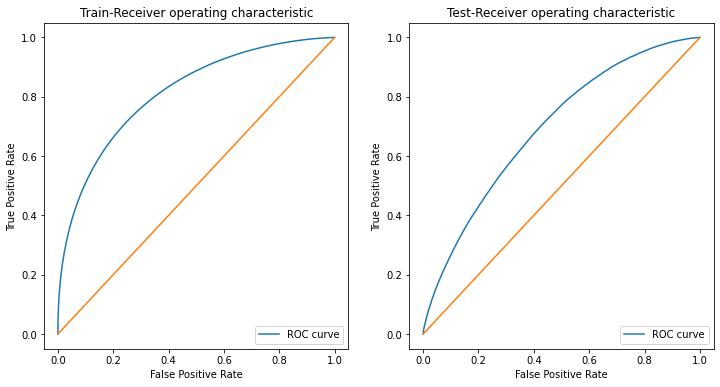

In [ ]:
plot_ROC(final_model, X_train, y_train, test[features], test.ext_labels, True, False)

In [ ]:
naiveScoreFunction(final_model, test[features], test.ext_labels)

0.2421952996823054

In [ ]:
naiveScoreFunction(final_model, train[features], train.ext_labels)

0.5890862218555944

In [ ]:
recall_score(test.ext_labels, final_model.predict(test[features]))

0.7161249944119094

In [ ]:
precision_score(test.ext_labels, final_model.predict(test[features]))

0.15849515843909132

In [ ]:
roc_auc_score(test.ext_labels, final_model.predict(test[features]))

0.6379662297272828

In [ ]:
accuracy_score(test.ext_labels, final_model.predict(test[features]))

0.5760272256943263

# Maximal Marginal Relevance

## Library import

In [103]:
import text_summarization_utility as tsu
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import pickle
import time
import ast

In [12]:
test_doc = pd.read_json(root+'test.json', orient='records', lines=True)
test_feature = pd.read_csv(root2+'test.csv')

In [13]:
with open(root+'final_model.pickle', 'rb') as f:
    final_model = pickle.load(f)

In [14]:
final_model

HistGradientBoostingClassifier(class_weight={0: 1, 1: 3}, learning_rate=0.05,
                               max_iter=500, random_state=100, verbose=2)

In [ ]:
test_doc.head()

,id,document,summary,ext_labels,rg_labels,document_normalized,pos_tags
0,train-TLDR_RC_2018-10-cm-19097.json,"[u / danieldrepper und ich hier ., wir sehen ...",wir versuchen sehr gute berschriften frs sozia...,"[0, 0, 0, 0, 1]","[0.2253879668, 0.1738707173, 0.0, 0.1241933695...","[[danieldrepper, und, ich, hier], [wir, sehen,...","[[NOUN, NOUN, VERB, ADJ], [NOUN, NOUN, NOUN, A..."
1,train-TLDR_RS_2013-03-21448.json,[we 've only been dating since august of last ...,wonderful relationship ruined by depression . ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0036682344, 0.0046148755, 0.007153057000000...","[[dating, since, august, last, year, one, poin...","[[VERB, ADP, NOUN, ADJ, NOUN, NUM, NOUN, NOUN,..."
2,train-TLDR_RS_2012-04-12146.json,[i can not for the life of me find a school fo...,"i need a school somewhat near pleasanton , ca","[0, 0, 1, 0]","[0.2685917512, 0.0831254313, 0.5420669887, 0.1...","[[life, find, school, wing, chun, eager, learn...","[[NOUN, VERB, NOUN, VERB, NOUN, NOUN, VERB], [..."
3,train-TLDR_RC_2018-10-cm-10081.json,[as a mixed chinese malay i would like to put ...,life is n't so black and white . experiences i...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0.0616566054, 0.0616566054, 0.0334707286, 0.0...","[[mixed, chinese, malay, would, like, put, pri...","[[ADJ, ADJ, NOUN, VERB, VERB, VERB, ADJ, NOUN,..."
4,train-TLDR_RC_2013-04-cm-47367.json,"[that does make more sense ., i just thought ...","i have lived here for 2 years , no problems in...","[0, 1, 0, 1, 0]","[0.0, 0.25816618210000003, 0.2298092281, 0.456...","[[make, sense], [thought, renting, condo, apar...","[[NOUN, NOUN], [VERB, VERB, ADJ, NOUN, VERB, V..."


In [49]:
test_feature.iloc[-1]['document_index']

40280.0

In [15]:
TF_ISF = test_doc['document_normalized'].iloc[test_feature['document_index'].unique()].apply(tsu.TF_ISF)

In [1]:
def MMR_selection(doc_index):

    model = final_model
    features_matrix = test_feature
    features = test_feature.columns.delete([0,-1])
    doc_matrix = test_doc
    tf_isf = TF_ISF
    lambda_ = 0.05

    doc = doc_matrix.iloc[doc_index:doc_index+1]
    doc_features = features_matrix[features_matrix['document_index']==doc_index][features]
    doc_tf_idf = tf_isf[doc_index]

    summary_proba = model.predict_proba(doc_features)[:,1]
    
    sort_descending_index = np.argsort(summary_proba)[-1::-1]

    S = {}

    for i in range(len(sort_descending_index)):
      if i == 0:
        S[i] = (sort_descending_index[i], doc['document'].values[0][sort_descending_index[i]])
      else:
        in_summary = [idx[0] for idx in S.values()]
        not_in_summary = [idx for idx in range(len(summary_proba)) if idx not in in_summary]


        MR = {} 
        for idx in not_in_summary:
          cs = cosine_similarity(doc_tf_idf[idx], doc_tf_idf[in_summary])
          MR[idx] = lambda_*summary_proba[idx] - (1-lambda_)*np.max(cs)
     

        MMR_idx = max(MR, key=MR.get)
        S[i] = (MMR_idx, doc['document'].values[0][MMR_idx])
      
    
    return S

In [111]:
def Summary_n_sentences(MMR_doc, how='auto'):
  if type(how) == int:
    n = how
  elif how == 'auto':
    if np.sqrt(len(MMR_doc)) > 1:
      n = int(np.sqrt(len(MMR_doc)))-1
    else:
      n = 1

  summary_list = [MMR_doc[i] for i in MMR_doc if i <=n]
  summary_list.sort(key=lambda y: y[0])
  summary_list = [e[1] for e in summary_list]

  summary = ''.join(summary_list)


  return summary

In [18]:
MMR_doc_list = []

In [50]:
for i in range(400):
  t1 = time.time()
  MMR_doc_list.append(pd.Series(test_feature['document_index'].unique()).iloc[i*100:(i+1)*100].apply(MMR_selection))
  print(time.time()-t1)

28.72699499130249
12.966118335723877


In [59]:
pd.Series([MMR_doc_list[i][j] for i in range(len(MMR_doc_list)-1) for j in range(i*100, (i+1)*100)]).to_csv('MMR_list_first_all.csv')

In [109]:
MMR_doc_list = pd.read_csv('MMR_list_first_all.csv')
MMR_doc_list = MMR_doc_list['0']
MMR_doc_list = pd.Series(map(ast.literal_eval, MMR_doc_list))

In [75]:
one_sentences_summaries = []
two_sentences_summaries = []
sqrt_sentences_summaries = []

In [102]:
MMR_doc_list.to_csv('/content/drive/MyDrive/Unimib/Text_Mining/MARCO SCATASSI TEXT PROJECT/MMR_doc_list.csv')

In [112]:
one_sentences_summaries.append(pd.Series(MMR_doc_list).apply(Summary_n_sentences, how=1))
two_sentences_summaries.append(pd.Series(MMR_doc_list).apply(Summary_n_sentences, how=2))
sqrt_sentences_summaries.append(pd.Series(MMR_doc_list).apply(Summary_n_sentences))

# Rouge Evaluation

In [23]:
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=599a3661b4a14f34e83fb4a1700451f398cf93da63c71ffe12305c2d6e9129e8
  Stored in directory: /root/.cache/pip/wheels/24/55/6f/ebfc4cb176d1c9665da4e306e1705496206d08215c1acd9dde
Successfully built rouge-score


In [24]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [113]:
one_sentence_scores = []
two_sentence_scores = []
sqrt_sentence_scores = []

In [119]:
for i in range(400):  
  for j in range(i*100, (i+1)*100):
    one_sentence_scores.append(scorer.score(one_sentences_summaries[0][i+j],
                                            test_doc['summary'].iloc[test_feature['document_index'].unique()].iloc[i+j]))
    
    two_sentence_scores.append(scorer.score(two_sentences_summaries[0][i+j],
                                            test_doc['summary'].iloc[test_feature['document_index'].unique()].iloc[i+j]))
  
    sqrt_sentence_scores.append(scorer.score(sqrt_sentences_summaries[0][i+j],
                                            test_doc['summary'].iloc[test_feature['document_index'].unique()].iloc[i+j]))

KeyError: ignored

In [121]:
one_sentence_scores_df = pd.DataFrame(list(map(lambda x: {'rouge1_precision': x['rouge1'][0]*100, 
                                     'rouge1_recall': x['rouge1'][1]*100,
                                     'rouge1_f1': x['rouge1'][2]*100,
                                     'rouge2_precision': x['rouge2'][0]*100, 
                                     'rouge2_recall': x['rouge2'][1]*100,
                                     'rouge2_f1': x['rouge2'][2]*100,
                                     'rougeL_precision': x['rougeL'][0]*100, 
                                     'rougeL_recall': x['rougeL'][1]*100,
                                     'rougeL_f1': x['rougeL'][2]*100
                                     }, one_sentence_scores)))

In [122]:
one_sentence_scores_df.describe()

,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
count,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000
mean,32.065711,22.658038,24.002528,10.977073,7.011689,7.627538,24.541505,16.778702,17.966826
std,18.911212,13.480177,11.923606,14.189890,8.632284,8.738399,16.652206,10.417994,9.763249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.181818,12.903226,15.384615,0.000000,0.000000,0.000000,12.500000,9.523810,11.111111
50%,29.166667,20.833333,23.404255,5.882353,4.545455,5.000000,20.689655,15.000000,16.666667
75%,42.857143,30.303030,32.000000,16.666667,10.638298,12.500000,33.333333,22.000000,23.728814
max,100.000000,100.000000,100.000000,100.000000,100.000000,95.774648,100.000000,100.000000,98.630137


In [123]:
two_sentence_scores_df = pd.DataFrame(list(map(lambda x: {'rouge1_precision': x['rouge1'][0]*100, 
                                     'rouge1_recall': x['rouge1'][1]*100,
                                     'rouge1_f1': x['rouge1'][2]*100,
                                     'rouge2_precision': x['rouge2'][0]*100, 
                                     'rouge2_recall': x['rouge2'][1]*100,
                                     'rouge2_f1': x['rouge2'][2]*100,
                                     'rougeL_precision': x['rougeL'][0]*100, 
                                     'rougeL_recall': x['rougeL'][1]*100,
                                     'rougeL_f1': x['rougeL'][2]*100
                                     }, two_sentence_scores)))

In [124]:
two_sentence_scores_df.describe()

,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
count,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000,39842.000000
mean,41.570335,19.553090,24.343898,14.706771,6.117135,7.829054,30.795320,13.818833,17.438422
std,19.415576,10.946743,10.516575,15.598097,6.405439,7.444500,17.431019,7.808477,8.079396
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.419355,11.666667,16.901408,2.439024,1.492537,2.083333,18.181818,8.333333,11.764706
50%,40.000000,17.777778,23.913043,11.111111,4.619831,6.349206,27.272727,12.500000,16.470588
75%,53.846154,25.581395,31.325301,22.222222,8.969575,12.048193,40.000000,17.647059,22.222222
max,100.000000,100.000000,95.652174,100.000000,93.333333,85.714286,100.000000,100.000000,95.652174


In [125]:
sqrt_sentence_scores_df = pd.DataFrame(list(map(lambda x: {'rouge1_precision': x['rouge1'][0]*100, 
                                     'rouge1_recall': x['rouge1'][1]*100,
                                     'rouge1_f1': x['rouge1'][2]*100,
                                     'rouge2_precision': x['rouge2'][0]*100, 
                                     'rouge2_recall': x['rouge2'][1]*100,
                                     'rouge2_f1': x['rouge2'][2]*100,
                                     'rougeL_precision': x['rougeL'][0]*100, 
                                     'rougeL_recall': x['rougeL'][1]*100,
                                     'rougeL_f1': x['rougeL'][2]*100
                                     }, sqrt_sentence_scores)))

In [127]:
sqrt_sentence_scores_df.describe()

,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1
count,39841.000000,39841.000000,39841.000000,39841.000000,39841.000000,39841.000000,39841.000000,39841.000000,39841.000000
mean,40.256824,20.166541,24.833132,13.289819,6.515579,7.987344,29.390801,14.439688,17.837020
std,17.679014,12.014543,11.491936,14.148101,7.790893,8.360127,15.689272,9.507025,9.394721
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28.333333,11.594203,16.666667,1.428571,0.833333,1.282051,18.518519,8.045977,11.382114
50%,39.682540,18.181818,24.242424,10.000000,4.347826,5.882353,26.666667,12.500000,16.326531
75%,50.000000,26.470588,32.258065,20.000000,9.375000,12.244898,37.500000,18.461538,22.857143
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


In [ ]:
sns.barplot(two_sentence_scores_df['rouge1_f1'], y='rouge1_f1')

ValueError: ignored